In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, SqueezeT, SqueezeN, DType, Pad, EmbedLookup, Reshape

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
#example icanswim/cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):
    
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)

    
feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                             'X2': ['feature_5'],
                                                             'embed': ['feature_3']},
                                             'criterion_input': {'target': ['feature_2'],
                                                                 'embed': ['feature_4']}},
                              'transforms': {'feature_1': [ExampleTransform(10), Pad((5,))],
                                             'feature_2': [Pad((3,3))],
                                             'feature_3': [Pad((4,)), EmbedLookup(feature_3)]},
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[1]

bang
CDataset created...


{'model_input': {'X1': array([10.04,  0.  ,  0.  ,  0.  ,  0.  ,  1.1 ]),
  'X2': array([1.1]),
  'embed': [array([1]), array([0]), array([0]), array([0])]},
 'criterion_input': {'target': array([[0.02, 0.03, 0.  ],
         [0.04, 0.05, 0.  ],
         [0.  , 0.  , 0.  ]]),
  'embed': array(['c', 'c', 'd'], dtype='<U1')}}

In [3]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': array([0.7822893 , 0.56034356, 0.23001231, 0.41568223, 0.04580396],
        dtype=float32)},
 'criterion_input': {'target': array([43.677605], dtype=float32)}}

In [4]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [],
                                             'X': [AsTensor()]},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 1000,
                                            'n_features': 30,
                                            'n_informative': 20,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_classification dataset...
CDataset created...


{'model_input': {'X': tensor([ 3.9179, -5.6532, -1.2942,  0.1554,  1.9787,  0.6364,  3.2545,  5.3095,
          -1.0111, -6.6931,  1.4968,  0.3119,  1.8520, -0.4526,  1.0043, -2.0735,
           2.8290, -0.0294,  2.3077,  0.5180, -0.7446,  2.7136, -0.4301, -2.4768,
          -4.5613, -0.5470,  0.0431,  1.4945, -2.3684,  0.5221])},
 'criterion_input': {'target': array([3])}}

In [5]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224>},
 'criterion_input': {'target': 0}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.918907
epoch: 0, lr: 0.01
train loss: 523774.2291666667, val loss: 353603.13636363635
learning time: 0:00:08.500808
epoch: 10, lr: 0.005
train loss: 7743.1080322265625, val loss: 6806.442205255682
test loss: 7511.206232244318
learning time: 0:00:13.760417


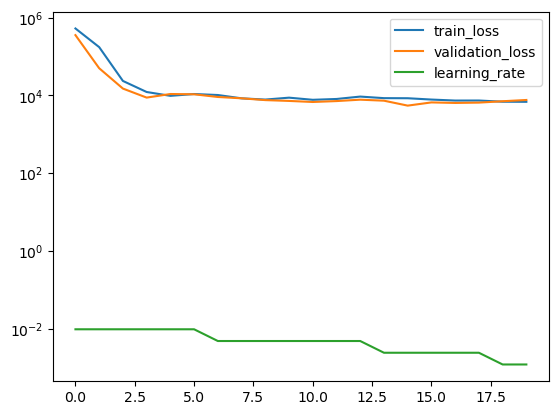

In [7]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.547467
epoch: 0, lr: 0.01
train loss: 0.01082373940089083, val loss: 0.010445794210028954
sklearn train metric: 0.5390404663402897, sklearn validation metric: 0.616156660627869
learning time: 0:00:14.216044
epoch: 3, lr: 0.01
train loss: 0.0086228052630079, val loss: 0.008479077408774795
sklearn train metric: 0.7772729603462764, sklearn validation metric: 0.7878311366119455
learning time: 0:00:24.854289
epoch: 6, lr: 0.01
train loss: 0.006926886988087342, val loss: 0.007133398439862534
sklearn train metric: 0.8637495831657201, sklearn validation metric: 0.8563330538774465
learning time: 0:00:35.321173
epoch: 9, lr: 0.01
train loss: 0.005600090569308226, val loss: 0.006050369109257928
sklearn train metric: 0.9113113064258199, sklearn validation metric: 0.8980601740071872
test loss: 0.0062049522709388
learning time: 0:00:35.801690


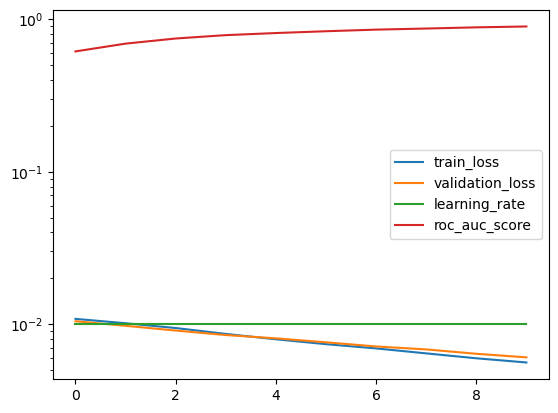

In [8]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [SqueezeN()],
                                             'X': []},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_redundant': 5,
                                            'n_repeated': 5,
                                            'n_clusters_per_class': 5,
                                            'flip_y': 0.05,
                                            'class_sep': 0.05,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), squeeze_y_pred=False, batch_size=128, epochs=10, save_model=False)

In [9]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {}

sample_params = {}

sched_params = {}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, load_model='20221025_1522.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2023-08-31 09:51:24.733957 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:04.894757
epoch: 0, lr: 0.01
train loss: 2.3754534916877748, val loss: 2.096600882468685
sklearn train metric: 0.609930135907187, sklearn validation metric: 0.7037865366797474
learning time: 0:00:15.590107
epoch: 3, lr: 0.01
train loss: 1.834508023262024, val loss: 1.8433587589571554
sklearn train metric: 0.7874912005944784, sklearn validation metric: 0.7995614292202554
test loss: 1.8478992345809937
learning time: 0:00:18.507183
sklearn test metric: 
0.7965719777777778 



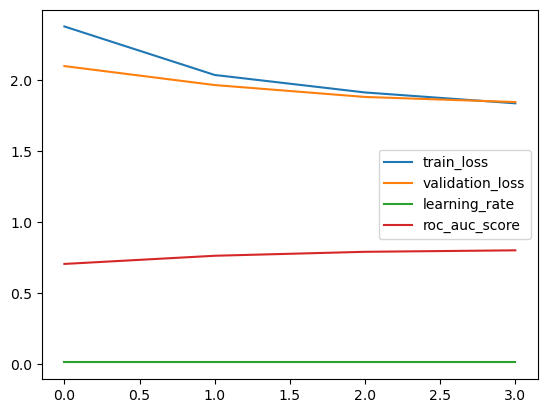

In [10]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:00:58.216645
epoch: 0, lr: 0.01
train loss: 2.6437419300079346, val loss: 2.159435631767396
sklearn train metric: 0.5540103269214415, sklearn validation metric: 0.651851716515365
learning time: 0:01:56.807279
epoch: 1, lr: 0.01
train loss: 2.11328635931015, val loss: 2.06958637122185
sklearn train metric: 0.6759955368324583, sklearn validation metric: 0.7063031785850853
learning time: 0:02:53.564917
epoch: 2, lr: 0.01
train loss: 2.0320035133361816, val loss: 1.9837506836460483
sklearn train metric: 0.7185226894819687, sklearn validation metric: 0.7525742039981876
learning time: 0:03:51.159967
epoch: 3, lr: 0.01
train loss: 1.9757986464500428, val loss: 1.9820716823301008
sklearn train metric: 0.7400052951668645, sklearn validation metric: 0.7548163481055603
test loss: 1.93867468967

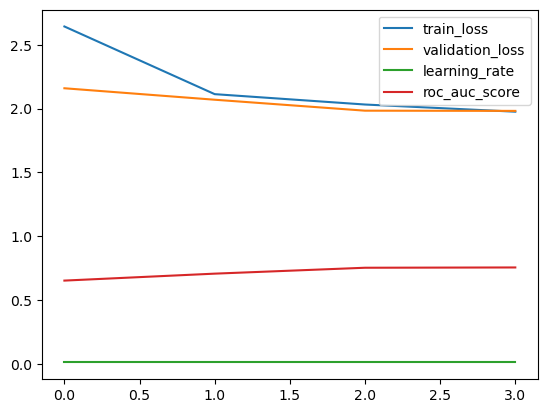

In [11]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)